# **Adding data to the Geoanalytics STAC server**

In [1]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer
!pip install boto3
!pip install rasterio
!pip install shapely
!pip install geojson

In [2]:
import io
import os
import sys
import time
import boto3
import shapely
import pickle
import getpass
import requests
import datetime
import json
import geojson
import glob
import dask
import rasterio
import gcsfs
import pystac
import stackstac
import planetary_computer

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt 

from json import JSONEncoder
from rasterio.warp import calculate_default_transform
from pathlib import Path
from dask.distributed import performance_report
from shapely.geometry import Polygon, mapping, shape
from shapely.ops import unary_union
from datetime import datetime
from itertools import islice
from pystac.extensions.projection import ProjectionExtension
from pystac.extensions.eo import Band
from pystac_client import Client
from dask_gateway import Gateway
from IPython.display import clear_output
from shapely import wkt
from shapely.geometry import box
from dateutil.parser import parse as dateparse
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from IPython.display import clear_output
from typing import Any, Dict, List, Optional, cast

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [39]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
options.image = 'pangeo/pangeo-notebook:2022.04.15' 

In [156]:
cluster = gateway.new_cluster(options)
cluster

In [157]:
# Scale the cluster
workers = 10
cluster.scale(workers) 

In [158]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [159]:
client.wait_for_workers(workers-1)
cluster

In [153]:
# client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: http://traefik-dask-gateway.geoanalytics.ca/services/dask-gateway/clusters/pangeo.d04033c287a04d9aa17050964cde3e66/status,


In [160]:
gateway.list_clusters()

[ClusterReport<name=pangeo.a253833fe1bf450f9d609a7d3230ce25, status=RUNNING>]

#### Remember to register for the gcsfs client, in order to access the Google Cloud Storage Buckets

In [161]:
def register_gcsfs_client(username:str):
    # set up the gcsfs system with credentials
    print('registering gcsfs')
    tok = os.path.join(os.environ['HOME'], f'geoanalytics_{username}', 'geo.json') # Change this to your own cred file
    tok_dict = json.load(open(tok))
    gcs = gcsfs.GCSFileSystem(token=tok_dict, access='read_write')
    return gcs

In [162]:
username = input('Username:')
gcs = register_gcsfs_client(username=username)

Username: mkavlin


registering gcsfs


In [163]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

<Client id=microsoft-pc>

## 1. Query the Sentinel 2 Data from PlanetaryComputer

In this section we will query Planetary Computer's STAC API as we have done in the past. However, we will add the additional step of downloading this data into our GeoAnalytics Google Cloud Storage bucket. This will enable us to host the data on our own STAC server. Making it easy for us to query and use.

In [164]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough outline of Quebec City,Quebec created using: https://www.keene.edu/campus/maps/tool/
polygon ={
  "coordinates": [
    [
      [
        -71.2405872,
        46.9847611
      ],
      [
        -71.2623882,
        46.9326235
      ],
      [
        -71.1655712,
        46.9171482
      ],
      [
        -71.145916,
        46.9711751
      ],
      [
        -71.2405872,
        46.9847611
      ]
    ]
  ],
  "type": "Polygon"
}

In [165]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-71.24059 46.98476, -71.26239 46.932..."


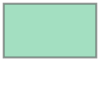

In [166]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [167]:
bounds = FOOTPRINT.bounds
print(bounds)

(-71.2623882, 46.9171482, -71.145916, 46.9847611)


## 2. Write functions to download the data, and create the STAC items

In the next section we will create a couple functions that will help us streamline our workflow.

If you wish to learn more about STAC Items follow this link to the STAC Item specification: https://github.com/radiantearth/stac-spec/tree/master/item-spec

In [168]:
# CONFIG 
# -------------
epsg = 32619
OUTPUT_DIR = 'stac_test'
BASE_PTH = 'gs://geoanalytics-user-shared-data'
YEARS = ['2019', '2020']
BEGIN_MONTH = '06'
END_MONTH = '09'
MAX_CLOUD = 5
config = {
'TGT_BANDS' :  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A'],
'READ_IN_CHUNK' : 4096,
'RESOLUTION' : 10,
'TEMPORAL_CHUNK' : {'time': -1, 'band': 1, 'x': 128, 'y': 128},
'SYNCHRONOUS' : True # Write bands out one at a time - use if resources can't handle all bands at once for AOI
}
# -------------

The **write_ras** function will take an XArray.DataArray, convert it into a Cloud Optimized GeoTIFF (COG) and save it to a path of our choice.

In [182]:
# Function to write from the dask cluster to the remote bucket
def write_ras(gcs, epsg, ras, b, pth):
    import rioxarray
    try:
        # ds = xr.Dataset()
        ras.rio.write_crs(epsg, inplace=True)
        ras.rio.to_raster('ras.tif')
        # Turn the raster into a COG
        dst_profile = cog_profiles.get("deflate")
        cog_translate(
            'ras.tif',
            'ras_cog.tif',
            dst_profile,
            in_memory=True,
            quiet=False,
            )
        # Use GCSFS Client to put COG into remote bucket
        gcs.put('ras_cog.tif', pth)
        # Clean up rasters on Dask Worker
        os.remove('ras.tif')
        os.remove('ras_cog.tif')
        return 'success'
    except Exception as e:
        # Return error and associated band
        return f'{b}: {e}'

The **create_stac_item** creates a STACitem, compiles the image's metadata, downloads the image using the **write_ras** function, and links the downloaded image to the STACitem. **create_stac_item** is a *dask.delayed* function which means it will not be computed by the dask clusters until *dask.compute()* is called on the funtion.

In [361]:
@dask.delayed
def create_stac_item(stac_item, image_name, out_path, data, time_acquired, config):
    print('\t[Converting STAC query to DataArray]')
    bbox = data.coords['proj:bbox'].values
    cog = f'{OUT_PTH}/{image_name}.tif'
    geom = FOOTPRINT

    # Instantiate pystac item
    new_stac_item = pystac.Item(id=image_name,
                                href=f'https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items/{image_name}',
                               geometry=mapping(geom),
                               bbox=FOOTPRINT.bounds,
                               datetime=time_acquired, 
                               properties={})
    
    # Extract metadata
    for key, value in stac_item['properties'].items():
        if key == 'time':
            new_stac_item.properties[key] = time_acquired

        elif key == 'id':
            new_stac_item.properties[key] = value
        else:
            new_stac_item.properties[key] = value
            
    new_stac_item.properties['original_links'] = stac_item['links']

    # Enable item extensions
    projection = ProjectionExtension.ext(new_stac_item, add_if_missing=True)
    projection.epsg = 32619
    

    
    # Add the link to the asset (the path to the geotiff)
    new_stac_item.add_asset(key='analytic', asset=pystac.Asset(href=cog,
                                                      title= "Cloud-optimized S2 L2 Image",
                                                      media_type=pystac.MediaType.COG,
                                                      roles=(["analytic"])))
    
    # return new_stac_item
    new_stac_item.validate()
    
    item_extent_info = (bbox, geom, time_acquired)

    raster = write_ras(gcs, epsg, data[0], image_name, f'{out_path}/{image_name}.tif')
    clear_output(wait=True)
    return (new_stac_item, raster, item_extent_info)

The following loop queries the Planetary Computer STAC API, creates an XArray.DataArray for each image, and calls *dask.compute()* on a list of *dask.delayed* outputs created by the **create_stac_item** to create our outputs.

In [ ]:
delayed_stac_items = []
for year in YEARS:
    OUT_PTH = f'{BASE_PTH}/{OUTPUT_DIR}/{year}'
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    stac_items = api.search(
            collections = ['sentinel-2-l2a'],
            intersects = FOOTPRINT,
            query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
            datetime = date_range,
        ).get_all_items()
    print(f'\tFound {len(items)} items')
    
    
    # PlanetaryComputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    
    # Iterate over bands and build composite DAG
    print(f'Creating STACitems')
    for stac_item in stac_items:
        item = planetary_computer.sign(stac_item)
        stac_item = stac_item.to_dict()
        time_acquired = datetime.strptime(stac_item['properties']['datetime'],'%Y-%m-%dT%H:%M:%S.%fZ')#stac_item.to_dict()['properties']['datetime'] #datetime.strptime(item['properties']['datetime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        print(time_acquired)
        # print(item)
        
        image_name = stac_item['id']
        data = (
            stackstac.stack(
                item,
                assets=config['TGT_BANDS'], 
                chunksize=config['READ_IN_CHUNK'], # Set chunksize
                resolution=config['RESOLUTION'], # Set all bands res
                bounds_latlon=FOOTPRINT.bounds # clip to AOI bounds
            ).where(lambda x: x > 0, other=np.nan)#.assign_coords(time=lambda x: x.time.dt.round("D"))  
        )
        
        delayed_stac_items.append(create_stac_item(stac_item, image_name, OUT_PTH, data, time_acquired, config))

with performance_report('dask_report.html'):
    comp_stac_items = dask.compute(delayed_stac_items)[0]

In [363]:
local_stac_items = []
local_item_extents = []
for stac_item, raster, item_extent_info in comp_stac_items:
    local_stac_items.append(stac_item)
    local_item_extents.append(item_extent_info)

print(local_stac_items)
print(local_item_extents)

[<Item id=S2A_MSIL2A_20190930T154041_R011_T19TCN_20201004T184543>]
[(array({300000.0, 5300040.0, 5190240.0, 409800.0}, dtype=object), <shapely.geometry.polygon.Polygon object at 0x7f72c580c5e0>, datetime.datetime(2019, 9, 30, 15, 40, 41, 24000))]


The following cell creates a couple functions that will help us visualize the footprint of our items. In this case all our items have the same footprint because we cut the images to a specific geometry in the download step. However, if you did not do that or if you were working in a larger area, these functions would help you visualize the area each image covers.

In [365]:
def create_full_extent(stac_item_list):
    polygons = []
    temporal_list = []
    
    for index, (bounds, geometry, temporal) in enumerate(stac_item_list):
        polygons.append(shape(geometry))
        temporal_list.append(temporal)
        
    # Get the spatial extent
    spatial_extent = get_spatial_extent(polygons)
    
    # Get temporal extent
    temporal_extent = get_temporal_extent(min(temporal_list), max(temporal_list))
    collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    return collection_extent


def get_spatial_extent(polygons):
    # Plot of polygons overlay
    plt.figure(figsize=(14, 8))
    for polygon in polygons:
        x, y = shape(polygon).exterior.xy
        plt.plot(x , y)

    # Returns a union of the two geojson polygons for each item
    unioned_geometry = unary_union(polygons)

    # Plot the unified polygon
    x, y = shape(unioned_geometry).exterior.xy
    plt.figure(figsize=(14,8))
    plt.fill(x, y, alpha=0.5, facecolor='none', edgecolor='purple', linewidth=7)
    plt.show()
    
    # Set the bbox to be the bounds of the unified polygon and return the spatial extent of the collection
    return pystac.SpatialExtent(bboxes=[unioned_geometry.bounds])


def get_temporal_extent(startime, endtime):
    time_interval = [startime, endtime]
    temporal_extent = pystac.TemporalExtent(intervals=[time_interval])
    return temporal_extent

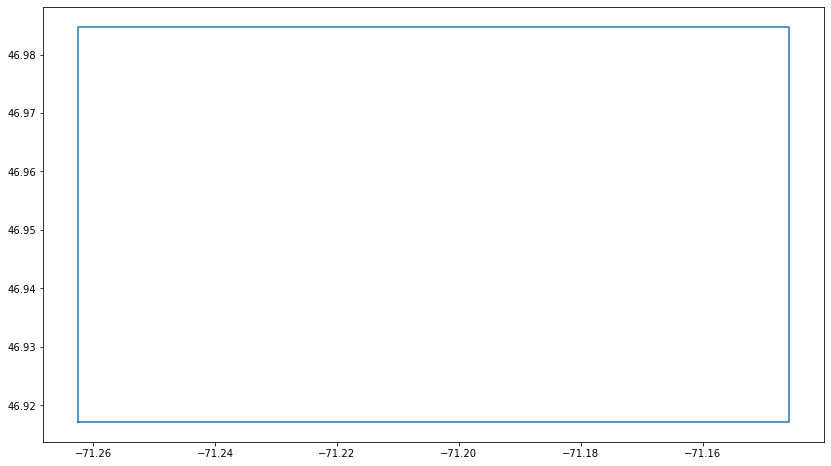

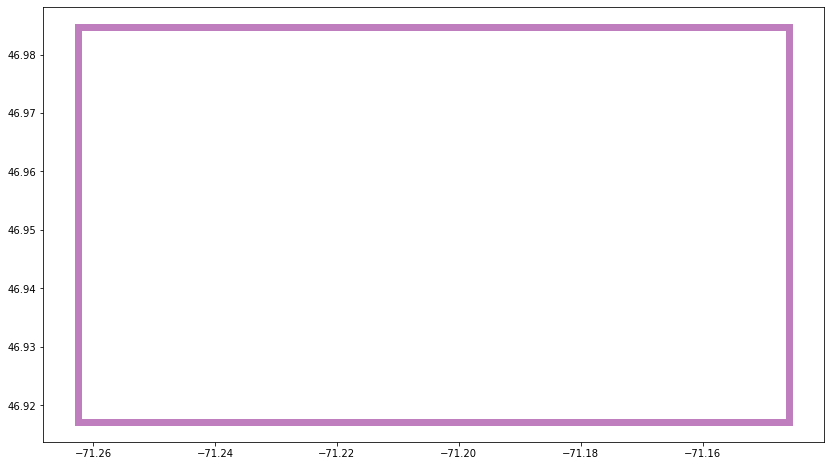

In [366]:
extent = create_full_extent(local_item_extents)

## 3. Create a STAC Collection to which append our STAC items 

Once we have our individual STAC items, we require somewhere to append them. To create a STAC collection we'll use the following parameters:

- ID: What we wish to call our collection.
- Title: Collection's title.
- Description: Details regarding the items within the collection.
- Extent: The spatial and temporal extent that we obtained from the create_full_extent function.
- Keywords: List of keywords describing the collection.
- Licence: Collection's license(s). (Set proprietary as the default)

If you wish to read up on STAC Collections follow this link: https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md


In [367]:
collection = pystac.Collection(id='Sentinel2_TEST',
                               href='https://stac.geoanalytics.ca/collections',
                               title='Sentinel 2: Level 2a Test for Quebec City over the years of 2019 and 2020',
                               description="Sentinel 2: Level 2a imagery covering Quebec City for the years of 2019 and 2020. Provides imagery of 10, 20, and 60m resolution (band dependent).",
                               extent=extent,
                               keywords=['sentinel2', 'msi','esa'],
                               license='proprietary',)

In [ ]:
collection.describe()
collection.validate()

In [ ]:
collection.to_dict()

Now that we have the Collection, we need to add the STAC items to the collection. 

In [ ]:
for index, item in enumerate(local_stac_items):
    print(index)
    collection.add_item(item)

In [ ]:
collection.describe()
collection.validate()

## 4. Add our completed collection to the GeoAnalytics STAC Server

To add our collection to the GeoAnalytics STAC server all we'll need is our GeoAnalytics Authorization Token, the collection URL for GeoAnalytics, and our local collection.

- First upload the structure of the Collection itself. 
- Second upload the individual STAC Item to the collection in GeoAnalytics.

In [ ]:
# Add Items and Collection to STAC Server

auth_token = input("Please copy and paste your API Access Token here: ").strip()

To add to the STAC server we use requests.post(), and to make updates to existing items we use requests.put(). Let's finish up by adding our STAC collection and STAC items to the Server!

In [377]:
headers={'cookie': auth_token}
data = json.dumps(collection.to_dict())
r = requests.post('https://stac.geoanalytics.ca/collections', data=data, headers=headers)

In [ ]:
print(r)

In [ ]:
%%time
headers={'cookie': auth_token}
for index, stac_item in enumerate(local_stac_items):
    print(stac_item)
    data2 = json.dumps(stac_item.to_dict())
    r = requests.post('https://stac.geoanalytics.ca/collections/Sentinel2_TEST/items', data=data2, headers=headers)
    print(r)

##### Now you know how to find data in a free STAC API, download it, and add it to your own STAC API for internal use. 

##### Don't forget to shutdown your clusters and close your client!

In [380]:
cluster.shutdown()
client.close()